# <center>Data 266 - Lab 1 - Part 1</center>
<p style="text-align: right;">Shao-Yu Huang 018195554<p>
<p style="text-align: right;">Akshit Tyagi <p>

## Building Large Language Model (LLM) from Scratch

### 1.1. Data Preprocessing
1. Load the dataset and tokenize the text at either the character level.
2. Create fixed-length input–target sequences suitable for autoregressive language
modelling.
3. Convert characters/words into integer encodings (e.g. using char_to_idx and
idx_to_char dictionaries)
4. Split the dataset into training (train: 100K) and validation (val: 10K) sets

In [ ]:
# Imports & Setup
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Device: cuda


In [11]:
# 1. Load dataset
ds = load_dataset("roneneldan/TinyStories")

subset = ds["train"].select(range(110_000))
train_ds = subset.select(range(100_000))
val_ds   = subset.select(range(100_000, 110_000))

# 2. Character-level tokenization
train_text = "\n".join(train_ds["text"])
val_text   = "\n".join(val_ds["text"])

print("Train stories:", len(train_ds), "| Val stories:", len(val_ds))
print("Train chars:", len(train_text), "| Val chars:", len(val_text))
print("\nSample:\n", train_text[:300])
print("-" * 100)

# 3. Build vocab + integer encodings
all_text = train_text + val_text
chars = sorted(list(set(all_text)))
vocab_size = len(chars)

char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

def encode(s: str):
    return [char_to_idx[c] for c in s]

def decode(ids):
    return "".join(idx_to_char[i] for i in ids)

max_train_tokens = 2_000_000   # 2M tokens only
max_val_tokens = 200_000

train_data = torch.tensor(encode(train_text[:max_train_tokens]), dtype=torch.long)
val_data   = torch.tensor(encode(val_text[:max_val_tokens]), dtype=torch.long)
# train_data = torch.tensor(encode(train_text), dtype=torch.long)
# val_data   = torch.tensor(encode(val_text), dtype=torch.long)

print("Vocab size:", vocab_size)
print("Encoded train:", train_data.shape, "| Encoded val:", val_data.shape)
print("-" * 100)

# 4. Create fixed-length input–target sequences (autoregressive)
class CharLMDataset(Dataset):
    """
    Returns (x, y) where:
      x = tokens[t : t+block_size]
      y = tokens[t+1 : t+block_size+1]
    """
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return max(0, self.data.size(0) - self.block_size - 1)

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Hyperparameters for data
block_size = 128
batch_size = 64

train_dataset = CharLMDataset(train_data, block_size)
val_dataset   = CharLMDataset(val_data, block_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

xb, yb = next(iter(train_loader))
print("Batch x:", xb.shape, "| Batch y:", yb.shape)
print("\nDecoded sample x:\n", decode(xb[0].tolist()[:200]))

Train stories: 100000 | Val stories: 10000
Train chars: 88406739 | Val chars: 9066149

Sample:
 One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and 
----------------------------------------------------------------------------------------------------
Vocab size: 110
Encoded train: torch.Size([2000000]) | Encoded val: torch.Size([200000])
----------------------------------------------------------------------------------------------------
Batch x: torch.Size([64, 128]) | Batch y: torch.Size([64, 128])

Decoded sample x:
 have to share with others. That is what yoga teaches us. To be kind and generous and grateful. Now, help me put everything back 


### 1.2. GPT Model Implementation
1. Implement one or more Transformer blocks from scratch, each consisting of:
 - Multi-Head Self-Attention
 - Layer Normalization
 - Feed-Forward Network
 - Residual connections
2. Use causal masking in self-attention to ensure the model does not access future
tokens during training.
3. Create learnable embedding layers for:
 - Token embeddings
 - Positional embeddings
4. Add a language modelling head that projects the final hidden representations to
the vocabulary size for next-token prediction.


includes: multi-head self-attention, casual mask, layernorm, residuals, token+pos embeddings, LM head

In [12]:
class MultiHeadSelfAttention(nn.Module):
    """
    Masked (causal) Multi-Head Self-Attention built from scratch.

    Steps:
    - Compute Q, K, V with a single linear layer
    - Reshape into (B, heads, T, head_dim)
    - Apply causal mask so token t can't attend to >t
    - Softmax attention weights, then weighted sum of V
    - Project back to d_model
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=True)
        self.proj = nn.Linear(d_model, d_model, bias=True)
        self.dropout = nn.Dropout(dropout)

        # We will create causal mask on the fly based on T

    def forward(self, x):
        B, T, C = x.shape  # C == d_model

        qkv = self.qkv(x)  # (B, T, 3C)
        q, k, v = qkv.split(C, dim=-1)  # each (B, T, C)

        # reshape to heads: (B, heads, T, head_dim)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # attention scores: (B, heads, T, T)
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        # causal mask: block future positions
        # mask shape: (T, T) where upper triangle is masked
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float("-inf"))

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = attn @ v  # (B, heads, T, head_dim)
        out = out.transpose(1, 2).contiguous().view(B, T, C)  # back to (B, T, C)

        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    """
    Standard Transformer FFN: Linear -> GELU -> Linear (with dropout).
    """
    def __init__(self, d_model: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class DecoderBlock(nn.Module):
    """
    GPT-style decoder block:
    - Pre-LN attention + residual
    - Pre-LN FFN + residual
    """
    def __init__(self, d_model: int, n_heads: int, dropout: float):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, dropout)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))  # residual connection
        x = x + self.ff(self.ln2(x))    # residual connection
        return x


class MiniGPT(nn.Module):
    """
    Decoder-only GPT:
    - Token embedding
    - Positional embedding
    - Stack of decoder blocks
    - Final LayerNorm
    - LM head to vocab
    """
    def __init__(self, vocab_size: int, block_size: int, d_model=256, n_heads=4, n_layers=4, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.d_model = d_model

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)

        self.blocks = nn.ModuleList([
            DecoderBlock(d_model, n_heads, dropout) for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx):
        """
        idx: (B, T) integer tokens
        returns logits: (B, T, vocab)
        """
        B, T = idx.shape
        assert T <= self.block_size, "Sequence length exceeds block_size"

        tok = self.token_emb(idx)  # (B, T, d_model)
        pos = self.pos_emb(torch.arange(T, device=idx.device))  # (T, d_model)
        x = tok + pos  # broadcast pos to (B, T, d_model)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits


# Model hyperparameters (keep moderate for speed)
d_model = 256
n_heads = 4
n_layers = 4
dropout = 0.1

model = MiniGPT(
    vocab_size=vocab_size,
    block_size=block_size,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    dropout=dropout
).to(device)

print("Model params:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

Model params: 3.24864 M


### 1.3. Training and Text Generation
1. Train the model using cross-entropy loss.
2. Implement learning rate warm-up and scheduling.
3. Train the model for a minimum of 10 epochs.
4. Plot and report training and validation loss curves.
5. Generate text samples using greedy decoding or temperature-based sampling.

Epoch 01/10 | Train Loss: 0.8620 | Val Loss: 0.9237
Epoch 02/10 | Train Loss: 0.6815 | Val Loss: 0.9627
Epoch 03/10 | Train Loss: 0.6239 | Val Loss: 1.0007
Epoch 04/10 | Train Loss: 0.5877 | Val Loss: 1.0320
Epoch 05/10 | Train Loss: 0.5611 | Val Loss: 1.0631
Epoch 06/10 | Train Loss: 0.5402 | Val Loss: 1.0845
Epoch 07/10 | Train Loss: 0.5234 | Val Loss: 1.1049
Epoch 08/10 | Train Loss: 0.5101 | Val Loss: 1.1196
Epoch 09/10 | Train Loss: 0.5007 | Val Loss: 1.1308
Epoch 10/10 | Train Loss: 0.4949 | Val Loss: 1.1382
Model saved as saved_model.pth
----------------------------------------------------------------------------------------------------


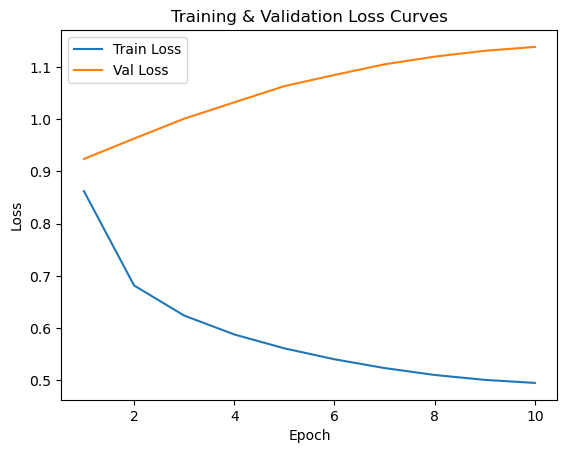

In [14]:
# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Learning rate warmup + cosine decay scheduler 
max_epochs = 10
warmup_steps = 500
max_steps = max_epochs * len(train_loader)

def get_lr(step, base_lr=3e-4, min_lr=3e-5):
    """
    Linear warmup to base_lr, then cosine decay down to min_lr.
    """
    if step < warmup_steps:
        return base_lr * (step + 1) / warmup_steps

    # cosine decay
    progress = (step - warmup_steps) / max(1, (max_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return min_lr + (base_lr - min_lr) * cosine

train_losses = []
val_losses = []

global_step = 0

for epoch in range(1, max_epochs + 1):
    # ---- Train ----
    model.train()
    total_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        lr = get_lr(global_step)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        logits = model(x)  # (B, T, vocab)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # stability
        optimizer.step()

        total_train_loss += loss.item()
        global_step += 1

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits.view(-1, vocab_size), y.view(-1))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


# Save trained model
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "vocab_size": vocab_size,
    "block_size": block_size,
}, "saved_model.pth")
print("Model saved as saved_model.pth")
print("-" * 100)

# Plot losses
plt.figure()
plt.plot(range(1, max_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, max_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.show()

In [15]:
# Text Generation (Greedy + Temperature Sampling)
@torch.no_grad()
def generate_greedy(prompt: str, max_new_tokens: int = 300):
    model.eval()
    ids = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        ids_cond = ids[:, -block_size:]
        logits = model(ids_cond)              # (1, T, vocab)
        next_id = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        ids = torch.cat([ids, next_id], dim=1)

    return decode(ids[0].tolist())


@torch.no_grad()
def generate_temperature(prompt: str, max_new_tokens: int = 300, temperature: float = 1.0):
    """
    Temperature sampling:
      - logits / temperature
      - sample from softmax distribution
    """
    model.eval()
    ids = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        ids_cond = ids[:, -block_size:]
        logits = model(ids_cond)
        logits_last = logits[:, -1, :] / max(1e-8, temperature)

        probs = F.softmax(logits_last, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)  # sample
        ids = torch.cat([ids, next_id], dim=1)

    return decode(ids[0].tolist())


prompt = "Once upon a time"
print("=== Greedy ===")
print(generate_greedy(prompt, max_new_tokens=400))

print("\n=== Temperature Sampling (T=0.9) ===")
print(generate_temperature(prompt, max_new_tokens=400, temperature=0.9))

=== Greedy ===
Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she went outside to play with her friends. One day, she went outside to play with her friends.

At the end of the day, Lily and Ben peek into the box and saw the box. They said, "Hello, Mia. We are the best. We are going to get you when you sleep. Boo!"

Lily screamed. She dropped her bag and ran back to the 

=== Temperature Sampling (T=0.9) ===
Once upon a time, there was a big blackboard bear who loved to explore. One day, the black bird was known as the most beautiful thing he had ever seen.

One day, 2 friends were playing in the garden when they heard a loud noise. One of them saw that the figure was not theirs. It felt good excited and let them on the scale. 

Sam watched the show and then flew away. Sam was very happy and flew away as fast as he c


### 1.4. Sequence Model Failure Analysis
Analyse three failure cases observed in the generated text. For each failure case, you must:
- Provide the generated text snippet you observe as a failure case.
- Identify the type of failure (e.g., repetition, broken grammar, loss of coherence,
hallucination) along with your observation.


In [21]:
# Generate a few samples (you can re-run and pick the best "failure" examples)
sample_1 = generate_greedy("Once upon a time", max_new_tokens=250)
sample_2 = generate_temperature("Once upon a time", max_new_tokens=250, temperature=1.1)
sample_3 = generate_temperature("Once upon a time", max_new_tokens=250, temperature=1.2)
sample_4 = generate_temperature("Once upon a time", max_new_tokens=250, temperature=0.9)

print("----- Sample 1 (Greedy) -----")
print(sample_1)
print("\n----- Sample 2 (Temp=1.1) -----")
print(sample_2)
print("\n----- Sample 3 (Temp=1.2) -----")
print(sample_3)
print("\n----- Sample 4 (Temp=0.9) -----")
print(sample_4)

----- Sample 1 (Greedy) -----
Once upon a time, there was a little girl named Lily. She loved to play outside in the sunshine. One day, she went outside to play with her friends. One day, she went outside to play with her friends.

At the end of the day, Lily and Ben peek into the box and saw th

----- Sample 2 (Temp=1.1) -----
Once upon a time, there was a little boy named Timmy. Timmy loved to ride his scooter too. He played games with his friends. One day, Timmy and his family went out to play. Timmy's tummy was very sad because his love dog.
Andy wanted a new toy, so he went outside at

----- Sample 3 (Temp=1.2) -----
Once upon a time, there was a lazy bear. He was hopping off in a sack with a big, pink shrimp. He wanted to crawl around the town, so he asked Sally noticed her foot what was wrong. The garden saw Millie and Timmy wanted on the floor. She smiled and rubbed it and re

----- Sample 4 (Temp=0.9) -----
Once upon a time there was a boy named Tom. Tom loved to play with his

1. Sample 1:
 - Failure Type: Repetition
 - Observation: The output repeatedly generates the sentence, "One day, she went outside to play with her friends." This is a failure of greedy decoding where the model selects the highest-probability next token at each step, leading to looped phrasing.

2. Sample 2:
 - Failure Type: Broken grammar and coherence collapse
 - Observation: The phrase "his love dog" is an incorrect possessove construction. Additionally, there is no consistent relationship between sentences. The paragraph begins with Timmy but abruptly introduces Andy, resulting in narrative inconsistency and loss of coherence.

3. Sample 3:
 - Failure Type: Coherence collapse and character confusion
 - Observation: The story becomes semantically nonsense, as shown in sentences such as "He was hopping off in a sack with a big, pink shrimp." and "so he asked Sally noticed her foot what was wrong." Another issue is that there are too many names appear within the paragraph, which may confuse the reader.

4. Sample 4:
 - Failure Type: Coherence collapse
 - Observation: The sentence "Tom loved to play with his friends, but he had a friend in the park." contains a logical inconsistency, as the contrast introduced by “but” is unclear and does not establish a meaningful contradiction.